In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import sys
import warnings
from pathlib import Path
from typing import Dict, Iterable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from rich import traceback
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

_ = traceback.install()
rpy2_logger.setLevel(logging.ERROR)
logging.basicConfig(force=True)
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [4]:
import rpy2.robjects as ro

from components.functional_analysis.orgdb import OrgDB
from r_wrappers.complex_heatmaps import complex_heatmap, heatmap_annotation
from r_wrappers.utils import map_gene_id

org_db = OrgDB("Homo sapiens")

In [5]:
ROOT_PATH: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED")
FIGURES_PATH: Path = ROOT_PATH.joinpath("manuscript_figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
ANNOT_DF = pd.read_csv(ROOT_PATH / "data" / "samples_annotation.csv", index_col=0)

VST_DF = pd.read_csv(
    ROOT_PATH / "deseq2" / "sample_type_hspc+mcrpc+norm+prim__vst.csv", index_col=0
)
VST_DF.index = map_gene_id(VST_DF.index, org_db, "ENSEMBL", "SYMBOL")
VST_DF = VST_DF.loc[~VST_DF.index.str.contains("/", na=False)]
VST_DF = VST_DF.loc[VST_DF.index.dropna().drop_duplicates(keep=False)]

CONTRASTS_LEVELS_COLORS = {
    "mcrpc": "#8B3A3A",
    "prim": "#4A708B",
    "hspc": "#8B008B",
    "norm": "#9ACD32",
}

CONTRASTS_LEVELS_ORDER = ["norm", "prim", "hspc", "mcrpc"]

## Integrative analysis of Differential Expression, WGCNA and ML results

---


## 1. Identify the most promising module combinations

In [7]:
results_path = ROOT_PATH / "integrative_analysis" / "intersecting_wgcna_pathways"
wgcna_int_results = {}

for int_wgcna_file in results_path.rglob("*.csv"):
    file_name = int_wgcna_file.stem
    if "up" in file_name or "down" in file_name:
        wgcna_int_results[file_name] = {
            "file_path": str(int_wgcna_file),
            "count": int(file_name.split("_")[-1]),
        }
wgcna_int_results_df = pd.DataFrame(wgcna_int_results).T.sort_values(
    "count", ascending=False
)

In [8]:
display(wgcna_int_results_df[:5].to_dict("index"))

{'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_20': {'file_path': '/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_pathways/REACTOME/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_20.csv',
  'count': 20},
 'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_1': {'file_path': '/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_pathways/DO/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_1.csv',
  'count': 1},
 'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M5+M2_0': {'file_path': '/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_pathways/REACTOME/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M5+M2_0.csv',
  'count': 0},
 'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecti

In [9]:
CHOSEN_PATH: Path = Path(wgcna_int_results_df.iloc[0]["file_path"])

In [10]:
WGCNA_INT_PATHWAYS_DF: pd.DataFrame = pd.read_csv(CHOSEN_PATH)
WGCNA_MODULES: Dict[str, str] = {
    "_".join(contrast.split("_")[:-1]): contrast.split("_")[-1]
    for contrast in WGCNA_INT_PATHWAYS_DF.columns[:3]
}

print(WGCNA_MODULES)

{'prim_vs_norm': 'M3', 'hspc_vs_prim': 'M2', 'mcrpc_vs_hspc': 'M1'}


## 2. Get shared genes between chosen WGCNA modules and ML results

Check average test scores per contrast

In [11]:
scores = {}
for test_scores_file in (ROOT_PATH / "ml_classifiers").rglob(
    "bootstrap_10000_test_scores.csv"
):
    test_scores_df = pd.read_csv(test_scores_file, index_col=0)
    scores[test_scores_file.parents[3].stem] = test_scores_df.mean()
pd.DataFrame(scores).T

""


Shared DEGs between WGCNA modules fltered by SHAP values

In [12]:
results_path = ROOT_PATH / "integrative_analysis" / "intersecting_wgcna"
ml_path_pattern = "_".join(CHOSEN_PATH.stem.split("_")[:-1]).replace(
    "intersecting_wgcna_pathways",
    "intersecting_wgcna",
)
wgcna_inter_results_path = next(results_path.glob(f"{ml_path_pattern}*.csv"))
print("Results file path:\n", wgcna_inter_results_path)
wgcna_inter_results = pd.read_csv(wgcna_inter_results_path, index_col=0)
print("Shape:\n", wgcna_inter_results.shape)
display(wgcna_inter_results)

Results file path:
 /media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_M3+M2+M1_ENTREZID_22.csv
Shape:
 (206, 8)


,prim_vs_norm_M3,hspc_vs_prim_M2,mcrpc_vs_hspc_M1,module,stat,SYMBOL,GENENAME,GENETYPE
ENTREZID,,,,,,,,
9232,True,True,True,M3,12.142774,PTTG1,PTTG1 regulator of sister chromatid separation...,protein-coding
1058,True,True,True,M3,14.746854,CENPA,centromere protein A,protein-coding
1063,True,True,True,M3,18.528588,CENPF,centromere protein F,protein-coding
9787,True,True,True,M3,17.270347,DLGAP5,DLG associated protein 5,protein-coding
24137,True,True,True,M3,19.737857,KIF4A,kinesin family member 4A,protein-coding
...,...,...,...,...,...,...,...,...
730101,False,False,True,M1,20.588473,LOC730101,uncharacterized LOC730101,ncRNA
80119,False,False,True,M1,7.225512,PIF1,PIF1 5'-to-3' DNA helicase,protein-coding
57464,False,False,True,M1,7.080411,STRIP2,striatin interacting protein 2,protein-coding


### 2.1. Heatmap of shared genes filtered by SHAP values

In [13]:
wgcna_inter_results_filt = wgcna_inter_results.loc[
    wgcna_inter_results["prim_vs_norm_M3"]
    & wgcna_inter_results["hspc_vs_prim_M2"]
    & wgcna_inter_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_inter_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [14]:
wgcna_inter_results_filt

,prim_vs_norm_M3,hspc_vs_prim_M2,mcrpc_vs_hspc_M1,module,stat,SYMBOL,GENENAME,GENETYPE
ENTREZID,,,,,,,,
9232,True,True,True,M3,12.142774,PTTG1,PTTG1 regulator of sister chromatid separation...,protein-coding
1058,True,True,True,M3,14.746854,CENPA,centromere protein A,protein-coding
1063,True,True,True,M3,18.528588,CENPF,centromere protein F,protein-coding
9787,True,True,True,M3,17.270347,DLGAP5,DLG associated protein 5,protein-coding
24137,True,True,True,M3,19.737857,KIF4A,kinesin family member 4A,protein-coding
55388,True,True,True,M3,12.942387,MCM10,minichromosome maintenance 10 replication init...,protein-coding
151648,True,True,True,M3,11.564943,SGO1,shugoshin 1,protein-coding
6241,True,True,True,M3,20.239389,RRM2,ribonucleotide reductase regulatory subunit M2,protein-coding
64151,True,True,True,M3,14.085327,NCAPG,non-SMC condensin I complex subunit G,protein-coding


In [15]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH
    / f"{wgcna_inter_results_path.stem}_shared_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=(
        "Shared genes between WGCNA modules M3 (prim vs norm), "
        "M2 (hspc vs prim) and M1 (mcrpc vs hspc)"
    ),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
)

### 2.2. Heatmap of genes filtered by SHAP values only in prim/norm

In [16]:
wgcna_inter_results_filt = wgcna_inter_results.loc[
    wgcna_inter_results["prim_vs_norm_M3"]
    & ~wgcna_inter_results["hspc_vs_prim_M2"]
    & ~wgcna_inter_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_inter_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [17]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH
    / f"{wgcna_inter_results_path.stem}_prim_norm_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=("Genes only in WGCNA module M3 (prim/norm)"),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
)

### 2.3. Heatmap of genes filtered by SHAP values only in hspc/prim

In [18]:
wgcna_inter_results_filt = wgcna_inter_results.loc[
    ~wgcna_inter_results["prim_vs_norm_M3"]
    & wgcna_inter_results["hspc_vs_prim_M2"]
    & ~wgcna_inter_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_inter_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [19]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH
    / f"{wgcna_inter_results_path.stem}_hspc_prim_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=("Genes only in WGCNA module M3 (hspc/prim)"),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
    row_names_gp=ro.r("gpar(fontsize = 8)"),
)

### 2.4. Heatmap of genes filtered by SHAP values only in mcrpc/hspc

In [20]:
wgcna_inter_results_filt = wgcna_inter_results.loc[
    ~wgcna_inter_results["prim_vs_norm_M3"]
    & ~wgcna_inter_results["hspc_vs_prim_M2"]
    & wgcna_inter_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_inter_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [21]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH
    / f"{wgcna_inter_results_path.stem}_mcrpc_hspc_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=("Genes only in WGCNA module M3 (mcrpc/hspc)"),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
)

## 3. Violin plots for key genes

In [22]:
key_genes: Iterable[str] = ["TPX2", "AR", "TROAP", "EZH2"]
prim_norm_degs_df = pd.read_csv(
    ROOT_PATH
    / "deseq2"
    / ("sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_deseq_results_unique.csv"),
    index_col=0,
)
hspc_prim_degs_df = pd.read_csv(
    ROOT_PATH
    / "deseq2"
    / ("sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_deseq_results_unique.csv"),
    index_col=0,
)
mcrpc_hspc_degs_df = pd.read_csv(
    ROOT_PATH
    / "deseq2"
    / ("sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_deseq_results_unique.csv"),
    index_col=0,
)

degs_dfs = {
    "prim_norm": prim_norm_degs_df.set_index("SYMBOL").loc[key_genes],
    "hspc_prim": hspc_prim_degs_df.set_index("SYMBOL").loc[key_genes],
    "mcrpc_hspc": mcrpc_hspc_degs_df.set_index("SYMBOL").loc[key_genes],
}

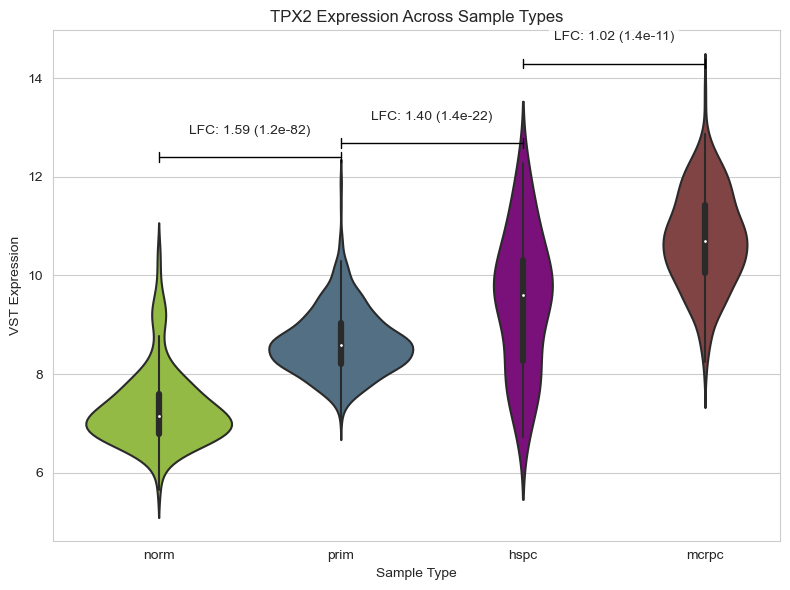

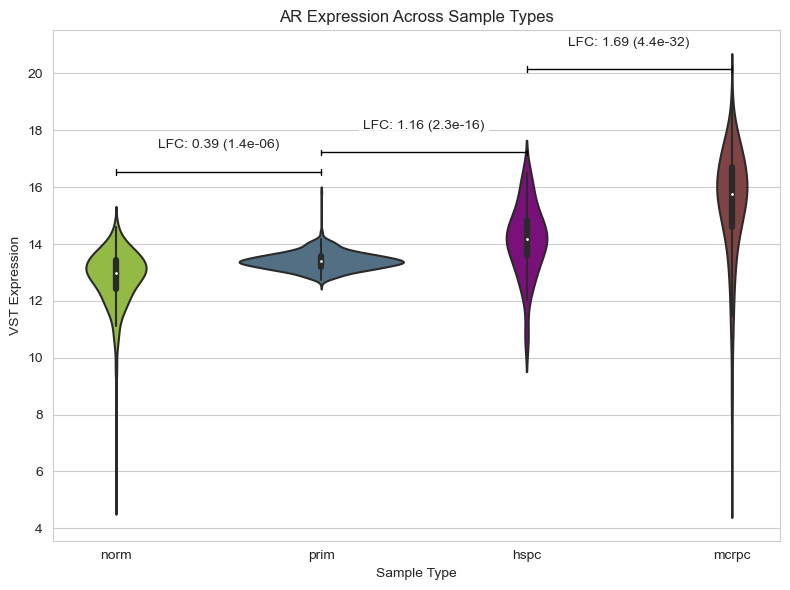

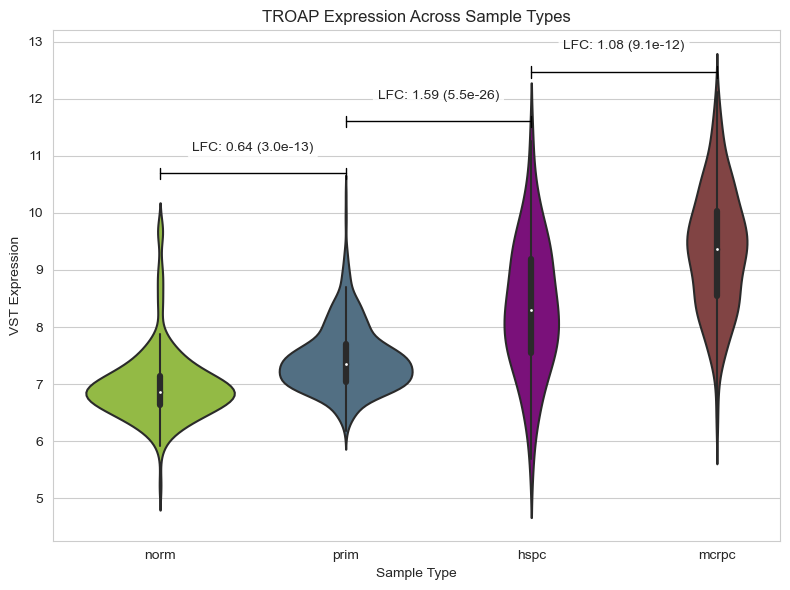

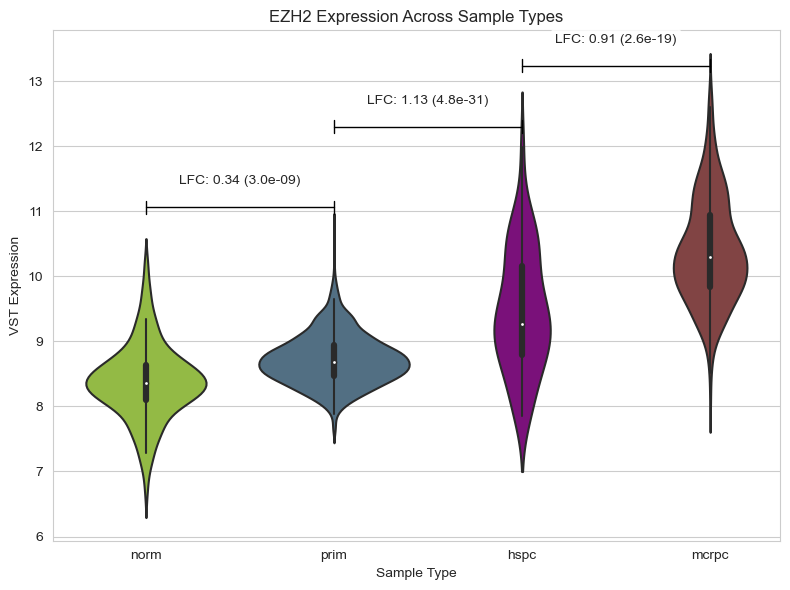

In [23]:
for key_gene in key_genes:
    # Get gene expression data
    key_gene_vst = VST_DF.loc[key_gene]

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(
        {
            "VST Expression": key_gene_vst,
            "Sample Type": ANNOT_DF.loc[key_gene_vst.index, "sample_type"],
        }
    )

    # Set style and figure size
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")

    # Create violin plot
    violin_plot = sns.violinplot(
        data=plot_df,
        x="Sample Type",
        y="VST Expression",
        order=CONTRASTS_LEVELS_ORDER,
        palette=CONTRASTS_LEVELS_COLORS,
    )

    # Add statistical annotations and horizontal lines
    for i in range(len(CONTRASTS_LEVELS_ORDER) - 1):
        first_level = CONTRASTS_LEVELS_ORDER[i]
        second_level = CONTRASTS_LEVELS_ORDER[i + 1]
        comparison = f"{second_level}_{first_level}"

        # Get statistical values
        log2fc = degs_dfs[comparison].loc[key_gene, "log2FoldChange"]
        padj = degs_dfs[comparison].loc[key_gene, "padj"]

        # Format annotation text
        annotation = f"LFC: {log2fc:.2f} ({padj:.1e})"

        # Calculate y positions for lines and text
        # Get the max value for each violin in the comparison
        violin1_data = plot_df[plot_df["Sample Type"] == first_level]["VST Expression"]
        violin2_data = plot_df[plot_df["Sample Type"] == second_level]["VST Expression"]
        max_height = max(violin1_data.max(), violin2_data.max())

        # Position text above the highest point
        text_y_pos = (
            max_height
            + (plot_df["VST Expression"].max() - plot_df["VST Expression"].min()) * 0.1
        )
        # Position line slightly below the text
        line_y_pos = (
            text_y_pos
            - (plot_df["VST Expression"].max() - plot_df["VST Expression"].min()) * 0.05
        )

        # Add annotation
        plt.annotate(
            annotation,
            xy=(i + 0.5, text_y_pos),
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        # Add horizontal line with whiskers
        plt.plot(
            [i, i + 1],
            [line_y_pos, line_y_pos],
            color="black",
            linestyle="-",
            linewidth=1,
        )
        plt.plot(
            [i, i],
            [line_y_pos - 0.1, line_y_pos + 0.1],
            color="black",
            linestyle="-",
            linewidth=1,
        )
        plt.plot(
            [i + 1, i + 1],
            [line_y_pos - 0.1, line_y_pos + 0.1],
            color="black",
            linestyle="-",
            linewidth=1,
        )

    # Customize plot
    plt.title(f"{key_gene} Expression Across Sample Types")
    plt.tight_layout()

    # Save plot
    plt.savefig(FIGURES_PATH / f"{key_gene.lower()}_expression_violin.pdf")
    plt.show()

## 4. Comparison of shared genes with OncotypeDx gene panel

In [24]:
ONCOTYPE_DX_GENES = [
    # Cancer-related genes
    "BGN",
    "COL1A1",
    "SFRP4",
    "AZGP1",
    "KLK2",
    "SRD5A2",
    "FAM13C",
    "FLNC",
    "GSN",
    "GSTM2",
    "TPM2",
    "TPX2",
    # Housekeeping genes
    "RF1",
    "ATP5E",
    "CLTC",
    "GPS1",
    "PGK1",
]

In [25]:
wgcna_inter_results_filt = wgcna_inter_results.loc[
    wgcna_inter_results["SYMBOL"].isin(ONCOTYPE_DX_GENES)
]
display(wgcna_inter_results_filt)

,prim_vs_norm_M3,hspc_vs_prim_M2,mcrpc_vs_hspc_M1,module,stat,SYMBOL,GENENAME,GENETYPE
ENTREZID,,,,,,,,
22974,True,True,True,M3,19.422131,TPX2,TPX2 microtubule nucleation factor,protein-coding
6424,True,False,False,M3,10.034569,SFRP4,secreted frizzled related protein 4,protein-coding
